In [12]:
from google.cloud import storage
bucket_name = "team4-project"

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)
my_prefix='imgs/euro/'
blobs = bucket.list_blobs(prefix = my_prefix, delimiter = '/')
print(blobs)
for blob in blobs:
    print(blob)

<Blob: team4-project, imgs/euro/.DS_Store, 1650537665680586>
<Blob: team4-project, imgs/euro/eval_set.csv, 1650784683158692>
<Blob: team4-project, imgs/euro/full_list.csv, 1650784528865700>
<Blob: team4-project, imgs/euro/train_list.csv, 1650755538061964>
<Blob: team4-project, imgs/euro/train_set.csv, 1650784681174392>
<Blob: team4-project, imgs/euro/val_list.csv, 1650755540087673>


In [13]:
blobs_all = list(bucket.list_blobs(prefix=my_prefix))
gcs_data = []
for x in blobs_all:
    #Select only image files
    if x.name.endswith(('.png','.jpg','.jpeg')):
        gcs_data.append(['gs://'+bucket_name+'/'+x.name,x.name.split('/')[-2]])

In [14]:
import pandas as pd

df = pd.DataFrame(gcs_data)
df2 = df[df[1].isin(['5','10','20','50'])]
print(df2)     
df2.to_csv('text.csv', index = False,header=False)
full_out_path=f'gs://{bucket_name}/{my_prefix}full_list.csv'
!gsutil cp 'text.csv' $full_out_path

                                                     0   1
0     gs://team4-project/imgs/euro/10/10-Euro-back.jpg  10
1          gs://team4-project/imgs/euro/10/10-Euro.jpg  10
2    gs://team4-project/imgs/euro/10/10euro_fr_ES1_...  10
3    gs://team4-project/imgs/euro/10/10euro_re_ES1_...  10
4    gs://team4-project/imgs/euro/10/ECB_10euro_Ban...  10
..                                                 ...  ..
750  gs://team4-project/imgs/euro/50/IMG_3755 Large...  50
751  gs://team4-project/imgs/euro/50/IMG_3756 Large...  50
752  gs://team4-project/imgs/euro/50/IMG_3757 Large...  50
753  gs://team4-project/imgs/euro/50/IMG_3758 Large...  50
754  gs://team4-project/imgs/euro/50/IMG_3759 Large...  50

[709 rows x 2 columns]
Copying file://text.csv [Content-Type=text/csv]...
/ [1 files][ 39.0 KiB/ 39.0 KiB]                                                
Operation completed over 1 objects/39.0 KiB.                                     


In [16]:
train_data = df2.sample(frac = 0.8)
train_data.to_csv('train_set.csv', index = False,header=False)
train_data_path = f'gs://{bucket_name}/{my_prefix}train_set.csv'
!gsutil cp 'train_set.csv' $train_out_path

# Creating dataframe with
# rest of the 50% values
eval_data = df2.drop(train_data.index)
eval_data.to_csv('eval_set.csv', index = False,header=False)
eval_data_path=f'gs://{bucket_name}/{my_prefix}eval_set.csv'
!gsutil cp 'eval_set.csv' $val_out_path

Copying file://train_set.csv [Content-Type=text/csv]...
/ [1 files][ 31.2 KiB/ 31.2 KiB]                                                
Operation completed over 1 objects/31.2 KiB.                                     
Copying file://eval_set.csv [Content-Type=text/csv]...
/ [1 files][  7.8 KiB/  7.8 KiB]                                                
Operation completed over 1 objects/7.8 KiB.                                      


In [17]:
CLASS_NAMES = df[1].unique()
print(train_data_path)
print(eval_data_path)
print("These are the available classes:", CLASS_NAMES)

gs://team4-project/imgs/euro/train_set.csv
gs://team4-project/imgs/euro/eval_set.csv
These are the available classes: ['10' '100' '20' '200' '5' '50' '500']


In [18]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(model, filename):
  f, ax = plt.subplots(7, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(35)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))
    ax[idx//5, idx%5].axis('off')

def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);a
    ax[flower].axis('off')
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)



# the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 dense_hidden (Dense)        (None, 16)                20496     
                                                                 
 flower_prob (Dense)         (None, 7)                 119       
                                                                 
Total params: 2,278,599
Trainable params: 20,615
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/10
18/18 [==============================] - 40s 2s/step - loss: 1.3448 - accuracy: 0.4550 - val_loss: 1.1824 - val_accuracy: 0.5704
Epoch 2/10
18/18 [==============================] - 32s 2s/step - loss: 0.9588 - ac

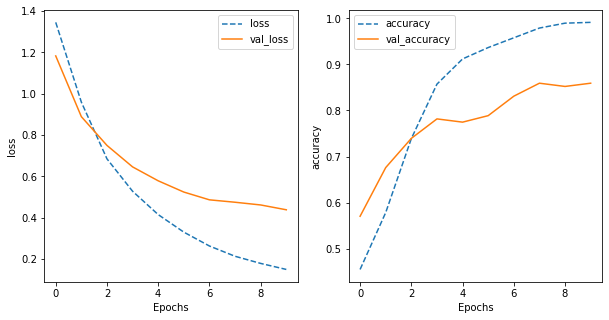

In [19]:
import tensorflow_hub as hub
import os
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset(
      train_data_path).
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      eval_data_path).
      map(decode_csv)).batch(32) # this doesn't matter

  layers = [
      
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          trainable=False,
          name='mobilenet_embedding'),
      # Added a rescaling layer
      #tf.keras.layers.Rescaling(1.0 / 255),
      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation='relu',
                            name='dense_hidden'),
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
  ]

  model = tf.keras.Sequential(layers, name='flower_classification')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

model = train_and_evaluate()

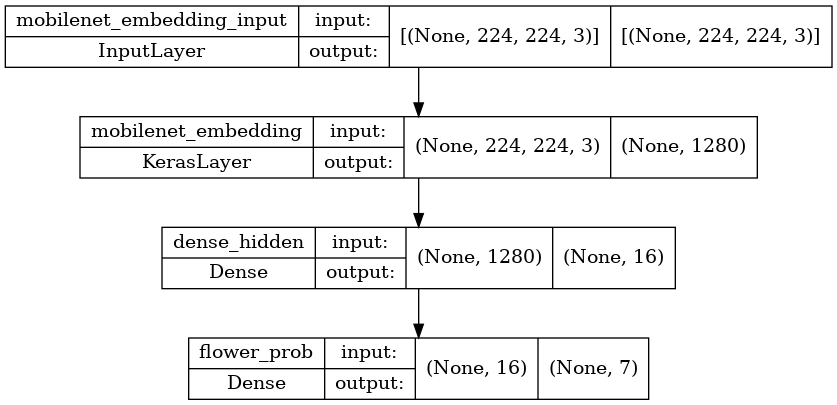

In [22]:
tf.keras.utils.plot_model(model, show_shapes=True)

gs://team4-project/imgs/euro/eval_set.csv


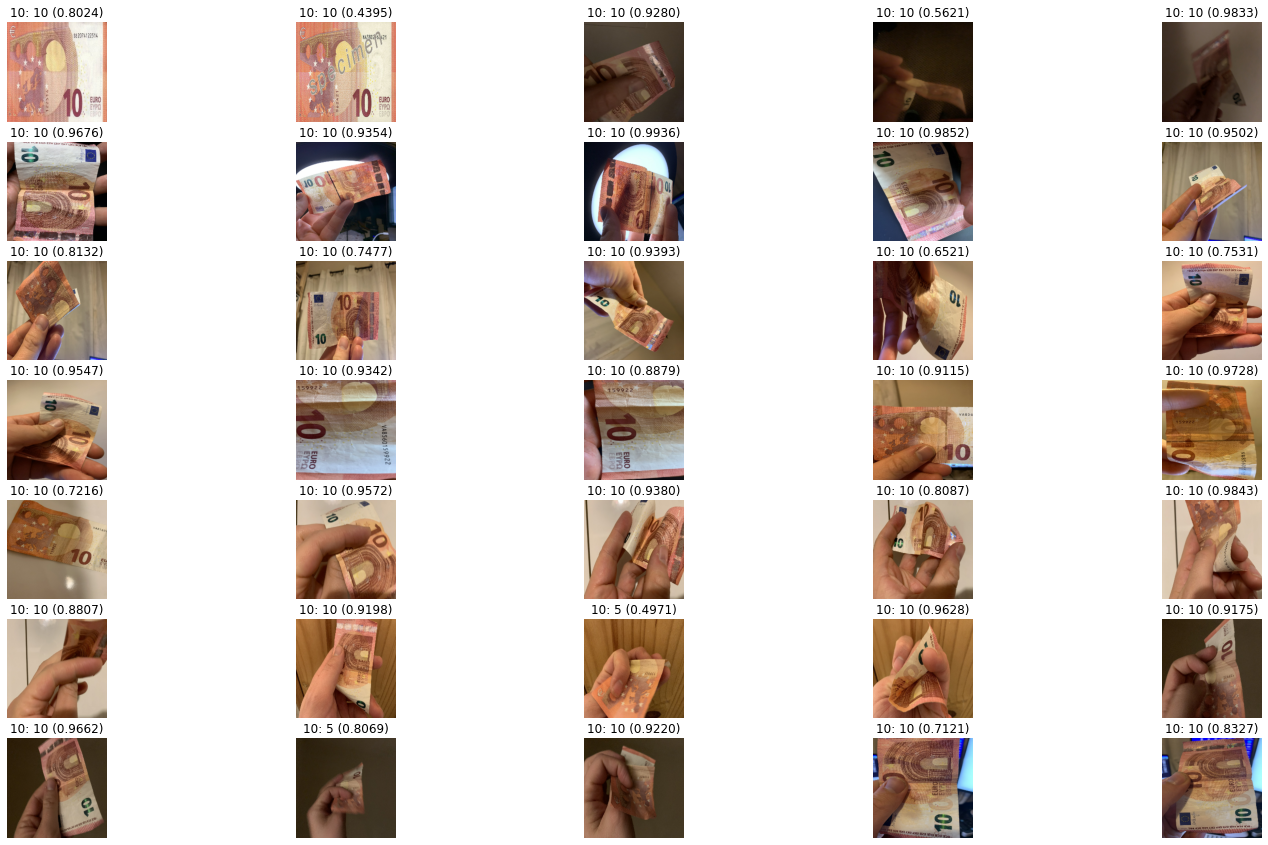

In [21]:
print(eval_data_path)
plot_predictions(model, eval_data_path)